In [1]:
### Importing the necessary Python libraries and data needed for the calculations of the time lag

# Python lib import 
import csv
import PyQt5
import warnings
import scipy as sc
import os
import math
import sys
from functools import reduce
from math import log
from scipy.stats import rankdata as rd
from scipy.stats import norm as nm
from scipy.stats import ttest_ind as tt
from scipy import optimize as op
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import argrelmin, argrelmax, find_peaks, detrend
from scipy.optimize import curve_fit, minimize
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.table import Table, Column

# Ignoring warnings printed to screen
warnings.filterwarnings("ignore")

hdulist = fits.open('../../../Real Data/Healthy_Control_Data/Four_dots_static.fits')
data = hdulist[0].data

# Getting t data
t = np.linspace(0,500,500)

# Extracting x data
x = [ [] for i in range(46)]
x11 = [[] for i in range(46)]

for i in range(46):

    x[i] = data[0,i,0,:]

for i in range(46):

    x11[i] = detrend(x[i], axis=-1, type='linear')

x1 = np.array(x11)

# Extracting y data
y = [ [] for i in range(46)]
y11 = [[] for i in range(46)]

for i in range(46):

    y[i] = data[0,i,1,:]

for i in range(46):

    y11[i] = detrend(y[i], axis=-1, type='linear')

y1 = np.array(y11)

# Finding r data
r1 = np.sqrt(x1**2 + y1**2)

In [2]:
### Creating a function to calculate mutual information between a time series x(t) and x(t + tau)

def MI_single(x0, x1, h='sturge', ranking=True):

    # Determining number of points for each input x0 and x1
    Nx0 = len(x0)
    Nx1 = len(x1)
    if Nx0 == Nx1:
        N = Nx0
    else:
        N = min([Nx0, Nx1])
    
    # Performing ranking of data
    if ranking == True:
        x0 = rd(x0, method='ordinal')
        x1 = rd(x1, method='ordinal')

    # Calculating the number of bins to use for the histograms x0, x1 abnd (x0,x1)
    if h == 'sturge':
        Bx0 = np.log2(Nx0) + 1
        Bx1 = np.log2(Nx1) + 1
        B = [Bx0, Bx1]
        B = np.round(np.array(B)).astype(int)     # Ensuring bin is an integer value
    
    # Calculating 1D histograms for x0 and x1
    Hx0 = np.histogram(x1, bins = int(B[0])) [0]
    Hx1 = np.histogram(x1, bins = int(B[1])) [0]

    #  Calculating 2D histogram for (x0, x1)
    Hx0x1 = np.histogram2d(x0, x1, bins = B) [0]

    # Working out the probabilities needed for the AMI factor
    Px0 = Hx0/N
    Px1 = Hx1/N
    Px0x1 = Hx0x1/N

    # Performing the AMI factor calculation 
    I_initial = Px0x1*np.log(Px0x1/(Px1*Px1))
    NaN_check = np.isnan(I_initial)                     # Checking which numbers in data are NaN  np.nansum
    I_initial[NaN_check] = 0                            # Changing NaN entries in series to 0
    I = sum(sum(I_initial))

    # Finishing off function and returning value I
    return(I)

In [3]:
### Creating a function to evaluate mutual information factor as a function of lag

def MI_time_delay(timeseries, plotting=True):

    # Initialising values and constants
    max_delay = 150
    I = []                     # Initialising AMI array
    tau = []                   # Initialising tau array 
    delay = 0

    # Performing the analysis
    while delay < max_delay:
        delay = delay + 1
        x0 = timeseries[:-delay]                # All terms besides last term
        x1 = timeseries[delay:]                 # All terms besides first term
        I.append(MI_single(x0,x1))
        tau.append(delay)

    return(tau, I)

In [4]:
def MI_minima(tau, I):

    # Calculating differences
    diffs = np.diff(I)                                                           # Calculating difference between each point in AMI factor
    zero_diffs = np.where(np.logical_and(diffs >= -2e-3, diffs <= 2e-3)) [0]     # Finding points where difference is within a small range around zero i.e. gradient = 0
    tau_array = np.array(tau)                                                    # Converting tau into an array
    
    return(tau[zero_diffs[0]])

In [5]:
### Function to compute takens emedded data for a specified delay and embedding dimension

def takens_embedding(data, delay, dimension):

    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceeds length of data')       # Ensures that delay is not going to be too large such that it is larger than the data length 
    
    embedded_data = np.array([data[0:len(data)-delay*dimension]])

    for i in range(1, dimension):
        embedded_data = np.append(embedded_data, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)

    return embedded_data;

In [6]:
### Function to calculate percentage of false nearest neighbours for a range of embedding dimensions 

def false_nearest_neighbors(data,delay,embedding_dimension):

    embedded_data = takens_embedding(data, delay, embedding_dimension);

    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embedded_data.transpose())
    distances, indices = nbrs.kneighbors(embedded_data.transpose())

    epsilon = np.std(distances.flatten())
    nFalseNN = 0

    for i in range(0, len(data)-delay*(embedding_dimension+1)):
        if (0 < distances[i, 1]) and (distances[i, 1] < epsilon) and ( (abs(data[i+embedding_dimension*delay] - data[indices[i,1]+embedding_dimension*delay]) / distances[i,1]) > 10):
            nFalseNN += 1;
    return nFalseNN

In [7]:
### Function to compute the power specttrum of the phase space

def power_spectrum(data_array,time):

    fouriert_1 = sc.fft.rfft(data_array, len(time))
    fourier_freq = sc.fft.rfftfreq(len(time), d = 1e-3)
    power_spec = np.abs(fouriert_1)**2

    return power_spec, fourier_freq

(0, 60)

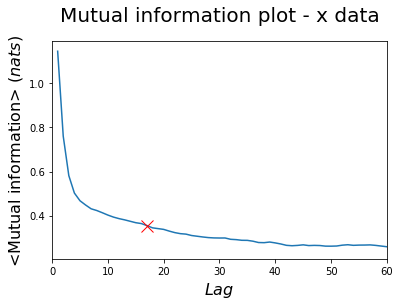

In [8]:
### Performing averaged mutual information in x for each repetition

# Setting up arrays
tau_x = [[] for i in range(46)]
I_x = [[] for i in range(46)]

# Determining averaged mutual information for each repetition 
for i in range(46):

    tau_x[i], I_x[i] = MI_time_delay(x1[i])

# Calculating mean averaged mutual information
tau_xav = np.sum(tau_x, axis=0)/46
I_xav = np.sum(I_x, axis=0)/46

# # Plotting mean averaged mutual information
plt.plot(tau_xav, I_xav)
plt.plot(tau_xav[16], I_xav[16], 'x', markersize=12, color='r')
plt.xlabel('$Lag$', fontsize=16)
plt.ylabel('<Mutual information> ($nats$)', fontsize=16)
plt.title('Mutual information plot - x data', fontsize=20, pad=20)
plt.xlim(0,60)

(0, 60)

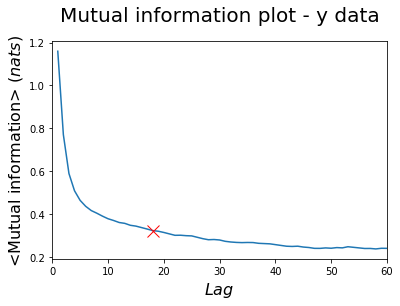

In [9]:
### Performing averaged mutual information in y for each repetition

# Setting up arrays 
tau_y = [[] for i in range(46)]
I_y = [[] for i in range(46)]

# Determining averaged mutual information for each repetition 
for i in range(46):

    tau_y[i], I_y[i] = MI_time_delay(y1[i])

# Calculating mean averaged mutual information
tau_yav = np.sum(tau_y, axis=0)/46
I_yav = np.sum(I_y, axis=0)/46

# Plotting mean averaged mutual information
plt.plot(tau_yav, I_yav)
plt.plot(tau_yav[17], I_yav[17], 'x', markersize=12, color='r')
plt.xlabel('$Lag$', fontsize=16)
plt.ylabel('<Mutual information> ($nats$)', fontsize=16)
plt.title('Mutual information plot - y data', fontsize=20, pad=20)
plt.xlim(0,60)

(0, 60)

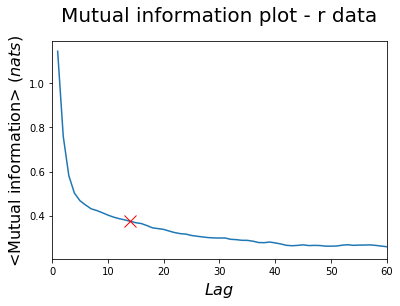

In [10]:
### Performing averaged mutual information in r for each repetition

# Setting up arrays 
tau_r = [[] for i in range(46)]
I_r = [[] for i in range(46)]

# Determining averaged mutual information for each repetition 
for i in range(46):

    tau_r[i], I_r[i] = MI_time_delay(r1[i])

# Calculating mean averaged mutual information
tau_rav = np.sum(tau_r, axis=0)/46
I_rav = np.sum(I_x, axis=0)/46

# Plotting mean averaged mutual information
plt.plot(tau_rav, I_rav)
plt.plot(tau_rav[13], I_rav[13], 'x', markersize=12, color='r')
plt.xlabel('$Lag$', fontsize=16)
plt.ylabel('<Mutual information> ($nats$)', fontsize=16)
plt.title('Mutual information plot - r data', fontsize=20, pad=20)
plt.xlim(0,60)

In [11]:
### Determining the values of tau for x data repetitions

tau_xvalues = [[] for i in range(46)]

for i in range(46):

    tau_xvalues[i] = MI_minima(tau_x[i], I_x[i])


# Calculating mean value of tau
tau_xmean = np.sum(tau_xvalues)/46

# Calculating standard deviation of tau
tau_sdx = np.std(tau_xvalues)

print('Mean lag in x direction =', np.int(tau_xmean))
print(tau_sdx)

Mean lag in x direction = 17
10.52661134049318


In [12]:
### Determining the values of tau for y data repetitons

tau_yvalues = [[] for i in range(46)]

for i in range(46):

    tau_yvalues[i] = MI_minima(tau_y[i], I_y[i])

# Calculating mean value of tau
tau_ymean = np.sum(tau_yvalues)/46

# Calculating standard deviation of tau
tau_sdy = np.std(tau_yvalues)

print('Mean lag in y direction =', np.int(tau_ymean))
print(tau_sdy)

Mean lag in y direction = 18
11.642598271775867


In [13]:
### Determining the values of tau for r data repetitions

tau_rvalues = [[] for i in range(46)]

for i in range(46):

    tau_rvalues[i] = MI_minima(tau_r[i], I_r[i])

# Calculating mean value of tau
tau_rmean = np.sum(tau_rvalues)/46

# Calculating standard deviation of tau
tau_sdr = np.std(tau_rvalues)

print('Mean lag in r direction =', np.int(tau_rmean))
print(tau_sdr)

Mean lag in r direction = 14
9.00149640993915


[7.98695652e-01 2.75521739e-01 5.04782609e-02 6.08695652e-03
 4.78260870e-04 1.73913043e-04]


Text(0.5, 1.0, 'False nearest neighbours vs dimension - x data')

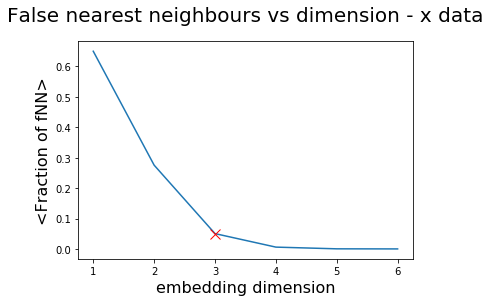

In [14]:
### False Nearest Neighbours for each x repetition

# Setting up arrays 
nFNN_x = [[] for i in range(46)]

# Calculating percentage of false nearest neighbours for each repetition
for i in range(46):

    for j in range (1,7):

        nFNN_x[i].append(false_nearest_neighbors(x1[i],tau_xvalues[i],j) / len(x1[i]))

# Calculating mean false nearest neighbours
nFNN_xav = np.sum(nFNN_x, axis=0)/46

nFNN_xav1 = [0.65, nFNN_xav[1], nFNN_xav[2], nFNN_xav[3], nFNN_xav[4], nFNN_xav[5]]

print(nFNN_xav)

# Plotting mean false nearest neighbours
plt.plot(range(1,7), nFNN_xav1)
plt.plot(3,nFNN_xav1[2],'x', color='red', markersize=10)
plt.xlabel('embedding dimension', fontsize=16);
plt.ylabel('<Fraction of fNN>', fontsize=16);
plt.title('False nearest neighbours vs dimension - x data', fontsize=20, pad=20)

[7.83565217e-01 2.61956522e-01 4.52173913e-02 6.47826087e-03
 5.65217391e-04 8.69565217e-05]


Text(0.5, 1.0, 'False nearest neighbours vs dimension - y data')

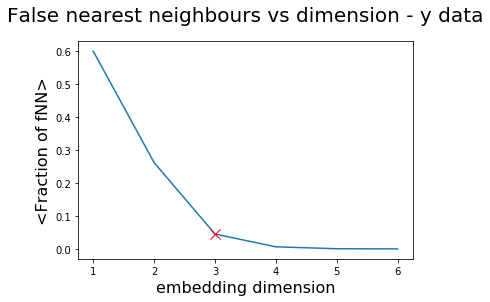

In [15]:
### False Nearest Neighbours for each y repetition

# Setting up arrays 
nFNN_y = [[] for i in range(46)]

# Calculating percentage of false nearest neighbours for each repetition
for i in range(46):

    for j in range (1,7):

        nFNN_y[i].append(false_nearest_neighbors(y1[i],tau_yvalues[i],j) / len(y1[i]))

# Calculating mean false nearest neighbours
nFNN_yav = np.sum(nFNN_y, axis=0)/46

nFNN_yav1 = [0.6, nFNN_yav[1], nFNN_yav[2], nFNN_yav[3], nFNN_yav[4], nFNN_yav[5]]

print(nFNN_yav)

# Plotting mean false nearest neighbours
plt.plot(range(1,7), nFNN_yav1)
plt.plot(3,nFNN_yav1[2],'x', color='red', markersize=10)
plt.xlabel('embedding dimension', fontsize=16);
plt.ylabel('<Fraction of fNN>', fontsize=16);
plt.title('False nearest neighbours vs dimension - y data', fontsize=20, pad=20)

[8.28043478e-01 3.23304348e-01 6.26521739e-02 9.30434783e-03
 1.08695652e-03 8.69565217e-05]


Text(0.5, 1.0, 'False nearest neighbours vs dimension - r data')

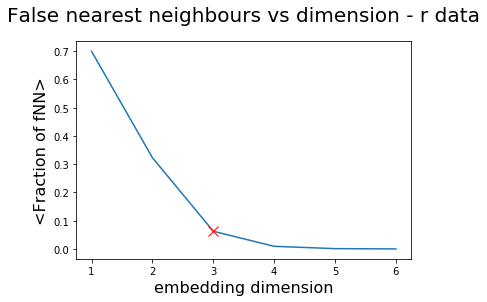

In [16]:
### False Nearest Neighbours for each r repetition

# Setting up arrays 
nFNN_r = [[] for i in range(46)]

# Calculating percentage of false nearest neighbours for each repetition
for i in range(46):

    for j in range (1,7):

        nFNN_r[i].append(false_nearest_neighbors(r1[i],tau_rvalues[i],j) / len(r1[i]))

# Calculating mean false nearest neighbours
nFNN_rav = np.sum(nFNN_r, axis=0)/46

nFNN_rav1 = [0.7, nFNN_rav[1], nFNN_rav[2], nFNN_rav[3], nFNN_rav[4], nFNN_rav[5]]

print(nFNN_rav)

# Plotting mean false nearest neighbours
plt.plot(range(1,7), nFNN_rav1)
plt.plot(3,nFNN_rav1[2],'x', color='red', markersize=10)
plt.xlabel('embedding dimension', fontsize=16);
plt.ylabel('<Fraction of fNN>', fontsize=16);
plt.title('False nearest neighbours vs dimension - r data', fontsize=20, pad=20)

Text(0.5, 0.92, 'Parkinsons - x')

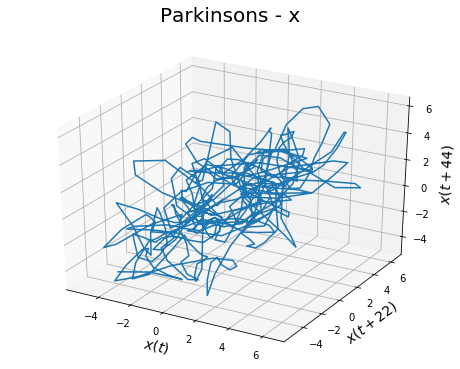

In [17]:
### Performing phase space reconstruction for x data 

# Embedding data 
embedded_x_final = []

for i in range(46):

    embedded_x_final.append(takens_embedding(x1[i],tau_xvalues[i],3))


# Plotting repetiton specific phase spaces
fig = plt.figure()
fig.set_size_inches(8,6)
ax = plt.axes(projection='3d')
ax.plot3D(embedded_x_final[10][0], embedded_x_final[10][1], embedded_x_final[10][2])
ax.set_xlabel('$x(t)$', fontsize=14)
ax.set_ylabel('$x(t+$'+str(tau_xvalues[0])+')', fontsize=14)
ax.set_zlabel('$x(t+$'+str(2*tau_xvalues[0])+')', fontsize=14)
ax.set_title('Parkinsons - x', fontsize=20, pad=40)

Text(0.5, 0.92, 'Parkinsons - y')

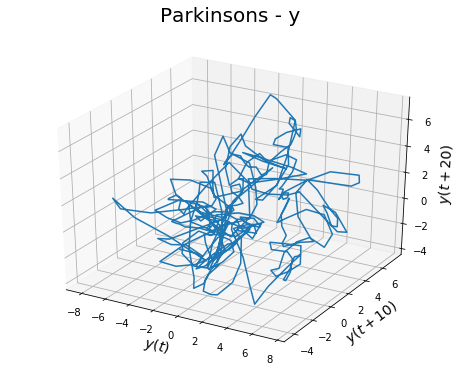

In [18]:
### Performing phase space reconstruction for y data 

# Embedding data
embedded_y_final = []

for i in range(46):

    embedded_y_final.append(takens_embedding(y1[i],tau_yvalues[i],3))

# Plotting repetiton specific phase spaces
fig = plt.figure()
fig.set_size_inches(8,6)
ax = plt.axes(projection='3d')
ax.plot3D(embedded_y_final[10][0], embedded_y_final[10][1], embedded_y_final[10][2])
ax.set_xlabel('$y(t)$', fontsize=14)
ax.set_ylabel('$y(t+$'+str(tau_yvalues[0])+')', fontsize=14)
ax.set_zlabel('$y(t+$'+str(2*tau_yvalues[0])+')', fontsize=14)
ax.set_title('Parkinsons - y', fontsize=20, pad=40)

Text(0.5, 0.92, 'Parkinsons - r')

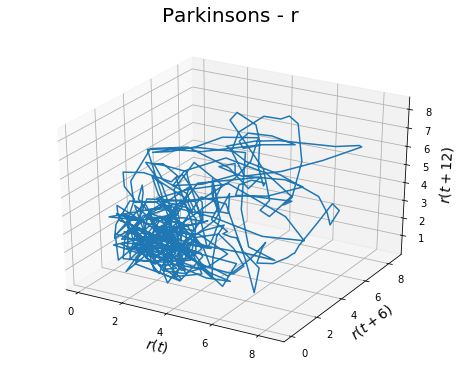

In [19]:
### Performing phase space reconstruction for r data 

# Embedding data
embedded_r_final = []

for i in range(46):

    embedded_r_final.append(takens_embedding(r1[i],tau_rvalues[i],3))


# Plotting repetiton specific phase spaces
fig = plt.figure()
fig.set_size_inches(8,6)
ax = plt.axes(projection='3d')
ax.plot3D(embedded_r_final[10][0], embedded_r_final[10][1], embedded_r_final[10][2])
ax.set_xlabel('$r(t)$', fontsize=14)
ax.set_ylabel('$r(t+$'+str(tau_rvalues[0])+')', fontsize=14)
ax.set_zlabel('$r(t+$'+str(2*tau_rvalues[0])+')', fontsize=14)
ax.set_title('Parkinsons - r', fontsize=20, pad=40)

In [20]:
### Power spectrum for each x repetition

# Setting up arrays
power_spectrum_x = []
freq_x = [[] for i in range(46)]
power_x = [[] for i in range(46)]
sum_fpx = [[] for i in range(46)]
sum_fx = [[] for i in range(46)]
mean_freqx = [[] for i in range(46)]
period_x = [[] for i in range(46)]


# Calculating the power spectrum for x data
for i in range(46):

    power_spectrum_x.append(power_spectrum(x1[i],t))

for i in range(46):
    
    freq_x[i] = power_spectrum_x[i][:][:][:][1]
    power_x[i] = power_spectrum_x[i][:][:][:][0]

for i in range(46):

    sum_fpx[i] = np.sum(freq_x[i]*power_x[i])
    sum_fx[i] = np.sum(freq_x[i])

for i in range(46):

    mean_freqx[i] = sum_fpx[i]/sum_fx[i]
    period_x[i] = 1/mean_freqx[i]


In [21]:
### Power spectrum for each y repetition

# Setting up arrays
power_spectrum_y = []
freq_y = [[] for i in range(46)]
power_y = [[] for i in range(46)]
sum_fpy = [[] for i in range(46)]
sum_fy = [[] for i in range(46)]
mean_freqy = [[] for i in range(46)]
period_y = [[] for i in range(46)]


# Calculating the power spectrum for x data
for i in range(46):

    power_spectrum_y.append(power_spectrum(y1[i],t))

for i in range(46):
    
    freq_y[i] = power_spectrum_y[i][:][:][:][1]
    power_y[i] = power_spectrum_y[i][:][:][:][0]

for i in range(46):

    sum_fpy[i] = np.sum(freq_y[i]*power_y[i])
    sum_fy[i] = np.sum(freq_y[i])

for i in range(46):

    mean_freqy[i] = sum_fpy[i]/sum_fy[i]
    period_y[i] = 1/mean_freqy[i]


In [22]:
### Power spectrum for each r repetition

# Setting up arrays
power_spectrum_r = []
freq_r = [[] for i in range(46)]
power_r = [[] for i in range(46)]
sum_fpr = [[] for i in range(46)]
sum_fr = [[] for i in range(46)]
mean_freqr = [[] for i in range(46)]
period_r = [[] for i in range(46)]


# Calculating the power spectrum for x data
for i in range(46):

    power_spectrum_r.append(power_spectrum(r1[i],t))

for i in range(46):
    
    freq_r[i] = power_spectrum_r[i][:][:][:][1]
    power_r[i] = power_spectrum_r[i][:][:][:][0]

for i in range(46):

    sum_fpr[i] = np.sum(freq_r[i]*power_r[i])
    sum_fr[i] = np.sum(freq_r[i])

for i in range(46):

    mean_freqr[i] = sum_fpr[i]/sum_fr[i]
    period_r[i] = 1/mean_freqr[i]


In [23]:
### Nearest neighbours for x data 

# Setting up arrays
nearest_neighbours_x = [[] for i in range(46)]
distances_x = [[] for i in range(46)]
indices_x = [[] for i in range(46)]

# Calculating nearest neighbours
for i in range(46):
    
    for j in range(len(x1[i])):

        nearest_neighbours_x[i] = NearestNeighbors(n_neighbors=200, algorithm='auto').fit(embedded_x_final[i].transpose())
        distances_x[i], indices_x[i] = nearest_neighbours_x[i].kneighbors(embedded_x_final[i].transpose())



In [24]:
### Nearest neighbours for y data 

# Setting up arrays
nearest_neighbours_y = [[] for i in range(46)]
distances_y = [[] for i in range(46)]
indices_y = [[] for i in range(46)]

# Calculating nearest neighbours
for i in range(46):
    
    for j in range(len(y1[i])):

        nearest_neighbours_y[i] = NearestNeighbors(n_neighbors=200, algorithm='auto').fit(embedded_y_final[i].transpose())
        distances_y[i], indices_y[i] = nearest_neighbours_y[i].kneighbors(embedded_y_final[i].transpose())



In [25]:
### Nearest neighbours for r data 

# Setting up arrays
nearest_neighbours_r = [[] for i in range(46)]
distances_r = [[] for i in range(46)]
indices_r = [[] for i in range(46)]

# Calculating nearest neighbours
for i in range(46):
    
    for j in range(len(r1[i])):

        nearest_neighbours_r[i] = NearestNeighbors(n_neighbors=200, algorithm='auto').fit(embedded_r_final[i].transpose())
        distances_r[i], indices_r[i] = nearest_neighbours_r[i].kneighbors(embedded_r_final[i].transpose())



In [26]:
### Divergence for x data 

# Initialising arrays needed for divergence calculation
N = 300
separation_x1 = [ [] for i in range(N)]
lags_x = []
xx_1 = [ [] for i in range(N)]
lyapunovs_x = []
lyapunovs_xerr = []
all_divergencex = [[] for i in range(46)]
 

for k in range(46):

    separation_x1 = [[] for i in range(N)]
    lags_x = []
    xx_1 = [[] for i in range(N)]

    eps = period_x[k] 
    oooo = embedded_x_final[k]
    indi = indices_x[k]

    # Extracting time differences between nearest neighbours
    for i in range(N):
        xx_1[i] = indi[i] - i

    xx_2 = np.array(xx_1)
    times_x = xx_2*1e-3

    for i in range(N):

        m_x = 0

        while np.abs(times_x[i][m_x]) < eps and m_x < 199:

            m_x = m_x + 1

        lags_x.append(times_x[i][m_x]) 

    lags_x1 = np.array(lags_x)/1e-3
    lags_x2 = lags_x1.astype(int)


    # Calculating the divergence for Lyapunov exponent calculation
    for i in range(0,N):
        
        for j in range(0,N):

            try:

                divv1 = np.sqrt((oooo[0,i+j+lags_x2[i]] - oooo[0,i+j])**2 + (oooo[1,i+j+lags_x2[i]] - oooo[1,i+j])**2 + (oooo[2,i+j+lags_x2[i]] - oooo[2,i+j])**2)
                separation_x1[j].append(divv1)

            except IndexError:
                separation_x1[j].append(np.nan)


    sep_x1 = np.array(separation_x1)

    # Taking the logarithm of the divergence array
    logsep_x1 = [ [] for i in range(len(sep_x1))]

    for i in range(N):

        logsep_x1[i] = np.log(sep_x1[i])

    logsep_x1 = np.array(logsep_x1)
    df_x=pd.DataFrame(logsep_x1)
    df_x_interpolate=df_x.interpolate(limit_direction='both')
    logsep_x2=pd.DataFrame.to_numpy(df_x_interpolate)

    # Calculating the averaged ln(divergence)
    av_log_div_x = np.mean(logsep_x2, axis = 1)
    df_xx=pd.DataFrame(av_log_div_x)
    df_xx=df_xx.replace(-np.inf, np.nan)
    df_xx_interpolate=df_xx.interpolate(limit_direction='both')
    av_log_div_x2=pd.DataFrame.to_numpy(df_xx_interpolate)

    # Performing the linear regression calculation
    t_regx = t[0:60].reshape(-1,1)
    divx_reg = av_log_div_x2[0:60].reshape(-1,1)

    reg_x = LinearRegression().fit(t_regx, divx_reg)
    grad_x = reg_x.coef_.item()
    intercept_x = reg_x.intercept_.item()

    resx = av_log_div_x2[0:60] - (t[0:60]*grad_x + intercept_x)
    resx_sq = np.sum(resx**2)
    tmeanx = np.mean(t[0:60])
    ttx = np.sum((t[0:60]-tmeanx)**2)

    error_x = np.sqrt((1/58)*(resx_sq/ttx))
    lyapunovs_x.append(grad_x)
    lyapunovs_xerr.append(error_x)
    all_divergencex[k].append(av_log_div_x2)

lyapunovs_xmean = np.mean(lyapunovs_x)
lyapunovs_sdx = np.std(lyapunovs_x)

print('The mean value of lyapunov exponents for x repetitions is', lyapunovs_xmean)
print(lyapunovs_sdx)

The mean value of lyapunov exponents for x repetitions is 0.00682280875051476
0.0023463441438323204


0.004650963595026601
0.0007044548379921494
0.7875636093584224
0.04427158981695002


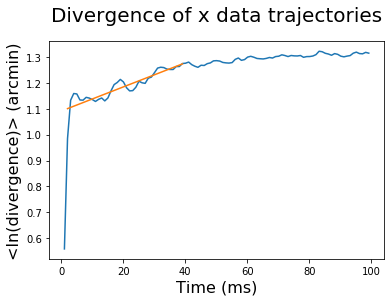

In [82]:
### Plotting averaged divergence for x data

av_divx = np.sum(all_divergencex, axis=0)/46

av_divx1=av_divx.reshape(300,)

# Performing the linear regression calculation
t_regx1 = t[2:40].reshape(-1,1)
divx_reg1 = av_divx1[2:40].reshape(-1,1)

reg_x1 = LinearRegression().fit(t_regx1, divx_reg1)
grad_x1 = reg_x1.coef_.item()
intercept_x1 = reg_x1.intercept_.item()

resx1 = av_divx1[2:40] - (t[2:40]*grad_x1 + intercept_x1)
resx_sq1 = np.sum(resx**2)
tmeanx = np.mean(t[2:40])
ttx1 = np.sum((t[2:40]-tmeanx)**2)

error_x1 = np.sqrt((1/38)*(resx_sq1/ttx1))

plt.plot(t[1:100], av_divx1[1:100])
plt.plot(t[2:40], t[2:40]*grad_x1 + intercept_x1)
plt.xlabel('Time (ms)', fontsize=16)
plt.ylabel('<ln(divergence)> (arcmin)', fontsize=16)
plt.title('Divergence of x data trajectories', fontsize=20, pad=20)

rscore_x = r2_score(av_divx1[2:40], t[2:40]*grad_x1 + intercept_x1)
mean_errx = mean_squared_error(av_divx1[2:40], t[2:40]*grad_x1 + intercept_x1)

print(grad_x1)
print(mean_errx)
print(rscore_x)
print(error_x1)

In [28]:
### Divergence for y data 

# Initialising arrays needed for divergence calculation
N = 300
separation_y1 = [ [] for i in range(N)]
lags_y = []
yy_1 = [ [] for i in range(N)]
lyapunovs_y = []
lyapunovs_yerr = []
all_divergencey = [[] for i in range(46)]
 

for k in range(46):

    separation_y1 = [[] for i in range(N)]
    lags_y = []
    yy_1 = [[] for i in range(N)]

    eps = period_y[k] 
    oooo = embedded_y_final[k]
    indi = indices_y[k]

    # Extracting time differences between nearest neighbours
    for i in range(N):
        yy_1[i] = indi[i] - i

    yy_2 = np.array(yy_1)
    times_y = yy_2*1e-3

    for i in range(N):

        m_y = 0

        while np.abs(times_y[i][m_y]) < eps and m_y < 199:

            m_y = m_y + 1

        lags_y.append(times_y[i][m_y]) 

    lags_y1 = np.array(lags_y)/1e-3
    lags_y2 = lags_y1.astype(int)


    # Calculating the divergence for Lyapunov exponent calculation
    for i in range(0,N):
        
        for j in range(0,N):

            try:

                divv1 = np.sqrt((oooo[0,i+j+lags_y2[i]] - oooo[0,i+j])**2 + (oooo[1,i+j+lags_y2[i]] - oooo[1,i+j])**2 + (oooo[2,i+j+lags_y2[i]] - oooo[2,i+j])**2)
                separation_y1[j].append(divv1)

            except IndexError:
                separation_y1[j].append(np.nan)


    sep_y1 = np.array(separation_y1)

    # Taking the logarithm of the divergence array
    logsep_y1 = [ [] for i in range(len(sep_y1))]

    for i in range(N):

        logsep_y1[i] = np.log(sep_y1[i])

    logsep_y1 = np.array(logsep_y1)
    df_y=pd.DataFrame(logsep_y1)
    df_y_interpolate=df_y.interpolate(limit_direction='both')
    logsep_y2=pd.DataFrame.to_numpy(df_y_interpolate)

    # Calculating the averaged ln(divergence)
    av_log_div_y = np.mean(logsep_y2, axis = 1)
    df_yy=pd.DataFrame(av_log_div_y)
    df_yy=df_yy.replace(-np.inf, np.nan)
    df_yy_interpolate=df_yy.interpolate(limit_direction='both')
    av_log_div_y2=pd.DataFrame.to_numpy(df_yy_interpolate)

    # Performing the linear regression calculation
    t_regy = t[0:60].reshape(-1,1)
    divy_reg = av_log_div_y2[0:60].reshape(-1,1)

    reg_y = LinearRegression().fit(t_regy, divy_reg)
    grad_y = reg_y.coef_.item()
    intercept_y = reg_y.intercept_.item()

    resy = av_log_div_y2[0:60] - (t[0:60]*grad_y + intercept_y)
    resy_sq = np.sum(resy**2)
    tmeany = np.mean(t[0:60])
    tty = np.sum((t[0:60]-tmeany)**2)

    error_y = np.sqrt((1/58)*(resy_sq/tty))
    lyapunovs_y.append(grad_y)
    lyapunovs_yerr.append(error_y)
    all_divergencey[k].append(av_log_div_y2)

lyapunovs_ymean = np.mean(lyapunovs_y)
lyapunovs_sdy = np.std(lyapunovs_y)

print('The mean value of lyapunov exponents for y repetitions is', lyapunovs_ymean)
print(lyapunovs_sdy)

The mean value of lyapunov exponents for y repetitions is 0.007433452504736227
0.003246786666313481


0.0052387047449761305
0.0008163441560710594
0.8023249931905605
0.046995040375738595


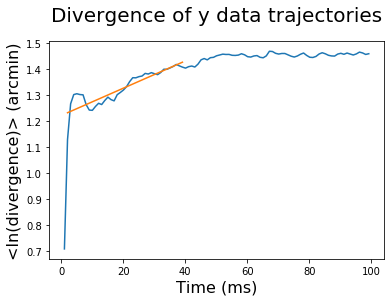

In [83]:
### Plotting averaged divergence for y data

av_divy = np.sum(all_divergencey, axis=0)/46

av_divy1=av_divy.reshape(300,)

# Performing the linear regression calculation
t_regy1 = t[2:40].reshape(-1,1)
divy_reg1 = av_divy1[2:40].reshape(-1,1)

reg_y1 = LinearRegression().fit(t_regy1, divy_reg1)
grad_y1 = reg_y1.coef_.item()
intercept_y1 = reg_y1.intercept_.item()

resy1 = av_divy1[2:40] - (t[2:40]*grad_y1 + intercept_y1)
resy_sq1 = np.sum(resy**2)
tmeany = np.mean(t[2:40])
tty1 = np.sum((t[2:40]-tmeany)**2)

error_y1 = np.sqrt((1/38)*(resy_sq1/tty1))

plt.plot(t[1:100], av_divy1[1:100])
plt.plot(t[2:40], t[2:40]*grad_y1 + intercept_y1)
plt.xlabel('Time (ms)', fontsize=16)
plt.ylabel('<ln(divergence)> (arcmin)', fontsize=16)
plt.title('Divergence of y data trajectories', fontsize=20, pad=20)

rscore_y = r2_score(av_divy1[2:40], t[2:40]*grad_y1 + intercept_y1)
mean_erry = mean_squared_error(av_divy1[2:40], t[2:40]*grad_y1 + intercept_y1)


print(grad_y1)
print(mean_erry)
print(rscore_y)
print(error_y1)

In [30]:
### Divergence for r data 

# Initialising arrays needed for divergence calculation
N = 300
separation_r1 = [ [] for i in range(N)]
lags_r = []
rr_1 = [ [] for i in range(N)]
lyapunovs_r = []
lyapunovs_rerr = []
all_divergencer = [[] for i in range(46)]
 

for k in range(46):

    separation_r1 = [[] for i in range(N)]
    lags_r = []
    rr_1 = [[] for i in range(N)]

    eps = period_r[k] 
    oooo = embedded_r_final[k]
    indi = indices_r[k]

    # Extracting time differences between nearest neighbours
    for i in range(N):
        rr_1[i] = indi[i] - i

    rr_2 = np.array(rr_1)
    times_r = rr_2*1e-3

    for i in range(N):

        m_r = 0

        while np.abs(times_r[i][m_r]) < eps and m_r < 199:

            m_r = m_r + 1

        lags_r.append(times_r[i][m_r]) 

    lags_r1 = np.array(lags_r)/1e-3
    lags_r2 = lags_r1.astype(int)


    # Calculating the divergence for Lyapunov exponent calculation
    for i in range(0,N):
        
        for j in range(0,N):

            try:

                divv1 = np.sqrt((oooo[0,i+j+lags_r2[i]] - oooo[0,i+j])**2 + (oooo[1,i+j+lags_r2[i]] - oooo[1,i+j])**2 + (oooo[2,i+j+lags_r2[i]] - oooo[2,i+j])**2)
                separation_r1[j].append(divv1)

            except IndexError:
                separation_r1[j].append(np.nan)


    sep_r1 = np.array(separation_r1)

    # Taking the logarithm of the divergence array
    logsep_r1 = [ [] for i in range(len(sep_r1))]

    for i in range(N):

        logsep_r1[i] = np.log(sep_r1[i])

    logsep_r1 = np.array(logsep_r1)
    df_r=pd.DataFrame(logsep_r1)
    df_r_interpolate=df_r.interpolate(limit_direction='both')
    logsep_r2=pd.DataFrame.to_numpy(df_r_interpolate)

    # Calculating the averaged ln(divergence)
    av_log_div_r = np.mean(logsep_r2, axis = 1)
    df_rr=pd.DataFrame(av_log_div_r)
    df_rr=df_rr.replace(-np.inf, np.nan)
    df_rr_interpolate=df_rr.interpolate(limit_direction='both')
    av_log_div_r2=pd.DataFrame.to_numpy(df_rr_interpolate)

    # Performing the linear regression calculation
    t_regr = t[0:60].reshape(-1,1)
    divr_reg = av_log_div_r2[0:60].reshape(-1,1)

    reg_r = LinearRegression().fit(t_regr, divr_reg)
    grad_r = reg_r.coef_.item()
    intercept_r = reg_r.intercept_.item()

    resr = av_log_div_r2[0:60] - (t[0:60]*grad_r + intercept_r)
    resr_sq = np.sum(resr**2)
    tmeanr = np.mean(t[0:60])
    ttr = np.sum((t[0:60]-tmeanr)**2)

    error_r = np.sqrt((1/58)*(resr_sq/ttr))
    lyapunovs_r.append(grad_r)
    lyapunovs_rerr.append(error_r)
    all_divergencer[k].append(av_log_div_r2)

lyapunovs_rmean = np.mean(lyapunovs_r)
lyapunovs_sdr = np.std(lyapunovs_r)

print('The mean value of lyapunov exponents for r repetitions is', lyapunovs_rmean)
print(lyapunovs_sdr)

The mean value of lyapunov exponents for r repetitions is 0.007598647812306313
0.0023519500400414938


0.005882727916389574
0.00042299982576604194
0.9080660153328737
0.04772389917783837


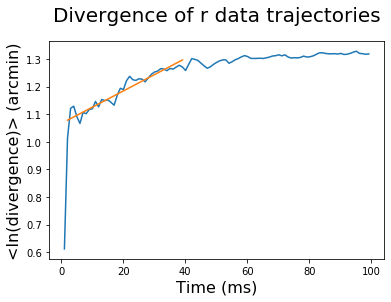

In [84]:
### Plotting averaged divergence for r data

av_divr = np.sum(all_divergencer, axis=0)/46

av_divr1=av_divr.reshape(300,)

# Performing the linear regression calculation
t_regr1 = t[2:40].reshape(-1,1)
divr_reg1 = av_divr1[2:40].reshape(-1,1)
reg_r1 = LinearRegression().fit(t_regr1, divr_reg1)
grad_r1 = reg_r1.coef_.item()
intercept_r1 = reg_r1.intercept_.item()

resr1 = av_divr1[2:40] - (t[2:40]*grad_r1 + intercept_r1)
resr_sq1 = np.sum(resr**2)
tmeanr = np.mean(t[2:40])
ttr1 = np.sum((t[2:40]-tmeanr)**2)

error_r1 = np.sqrt((1/38)*(resr_sq1/ttr1))

plt.plot(t[1:100], av_divr1[1:100])
plt.plot(t[2:40], t[2:40]*grad_r1 + intercept_r1)
plt.xlabel('Time (ms)', fontsize=16)
plt.ylabel('<ln(divergence)> (arcmin)', fontsize=16)
plt.title('Divergence of r data trajectories', fontsize=20, pad=20)

rscore_r = r2_score(av_divr1[2:40], t[2:40]*grad_r1 + intercept_r1)
mean_errr = mean_squared_error(av_divr1[2:40], t[2:40]*grad_r1 + intercept_r1)

print(grad_r1)
print(mean_errr)
print(rscore_r)
print(error_r1)

In [73]:
### Performing T-test between Parkinso's and control participant for x data

t_patientx = lyapunovs_x
t_controlx = [0.01765627331455689, 0.012681150466437757, 0.020516774227012393, 0.01497865336011384, 0.024826263834485114, 0.003848403480972742, 0.0075960087742760205, 0.005290220126460295, 0.010024605869547747, 0.0046611347492231375, 0.01438726685116858, 0.007784254129626441, 0.012539216669978632, 0.0165496486747158, 0.019613956695817572, 0.014048506763748882, 0.013387101499709127, 0.0031957656049769246, 0.011314532168966975, 0.012329519111002822, 0.014217457729683282, 0.012502313802872785, 0.010575841251180645, -0.001811745815571069, 0.007358029269456156, 0.01482539304261262, 0.015682957303024214, 0.007349580045030007, 0.016981321085743385, 0.008148401209969791, 0.007409589823571574, 0.01650054938199119, 0.012896785302120472, 0.008804631259729022, 0.013786305113871196, 0.015854212036596618, 0.009345630588459495, 0.02129832636742016, 0.014684630889070334, 0.010536314699870123, 0.012130646252518248, 0.010468336607669083, 0.0033527344517116434, 0.024080092867893536, 0.013161449552121143, 0.013348949519345897]

mu_patientx = np.mean(t_patientx)
mu_controlx = np.mean(t_controlx)

sd_patientx = np.std(t_patientx)
sd_controlx = np.std(t_controlx)

ttest_x = tt(t_patientx, t_controlx, equal_var=False)

print(ttest_x)

Ttest_indResult(statistic=-6.090856976043419, pvalue=8.107113565812528e-08)


In [71]:
### Performing T-test between Parkinso's and control participant for y data


t_patienty = lyapunovs_y
t_controly = [0.012091518616294098, 0.009617063793911114, 0.013434878302822952, 0.008601640969571757, 0.010629772891380654, 0.006931294083558354, 0.013128543199136965, 0.010755413649322879, 0.007903206125427447, 0.0034792393205341074, 0.01033118919853661, 0.013627067091286423, 0.004375798282837366, 0.008704021354279634, 0.013354422801471644, 0.005709847501466446, 0.010001335921914536, 0.004671442025859207, 0.010274859046992234, 0.014435301961783338, 0.014185719853848323, 0.008642276334979026, 0.00304532392613609, 0.01473113976583941, 0.006850422102636823, 0.02198247221294593, 0.009342299289652765, 0.007317987871017863, 0.01535495713604238, 0.015541316103450293, 0.0228309813307256, 0.006963518856875504, 0.00954109606036151, 0.014881959446830448, 0.012394804478609075, 0.01671536679217906, 0.006987805684691289, 0.00886045646160934, 0.013729810474534228, 0.0006672294582512612, 0.012955072826688556, 0.013342294498545331, 0.0015642796725073179, 0.0183889004420673, 0.009998403541726012, 0.003239411187907675]

mu_patienty = np.mean(t_patienty)
mu_controly = np.mean(t_controly)

sd_patienty = np.std(t_patienty)
sd_controly = np.std(t_controly)

ttest_y = tt(t_patienty, t_controly, equal_var=False)

print(ttest_y)

Ttest_indResult(statistic=-3.5080751992637516, pvalue=0.0007493743645488753)


In [72]:
### Performing T-test between Parkinso's and control participant for r data


t_patientr = lyapunovs_r
t_controlr = [0.00862650894620991, 0.01145501441727035, 0.011704609170525715, 0.007946948930618971, 0.002074605698874888, 0.012030899391247914, 0.007323469411608635, 0.003881599656066436, 0.0054276984903367095, 0.010231615570377266, 0.01570744869114812, 0.004690933897103241, 0.01052986566039031, 0.0038912000357811494, 0.004553397920629431, 0.01226044442607362, 0.01053612460092014, 0.011780003892878154, 0.006298778442053045, 0.01217274155236424, 0.013712610973577614, 0.013073112826029153, 0.019677729358045997, 0.01548252509939353, 0.015046267812602461, 0.018309674194871353, 0.012210327495170219, 0.008111996353173086, 0.017934982024765397, 0.004162850013121606, 0.020412372491909737, 0.013659342746329468, 0.020806587323689694, 0.008422607034058371, 0.013387021237338604, 0.011768698357185739, 0.008359318909562529, 0.005360318462392266, 0.013065100761320204, 0.006588513651044092, 0.008188146760605336, 0.006350501916374279, 0.011641041224455974, 0.014806440076471108, 0.01167615832341323, 0.009778057830912141]

mu_patientr = np.mean(t_patientr)
mu_controlr = np.mean(t_controlr)

sd_patientr = np.std(t_patientr)
sd_controlr = np.std(t_controlr)

ttest_r = tt(t_patientr, t_controlr, equal_var=False)

print(ttest_r)

Ttest_indResult(statistic=-4.123342856374396, pvalue=0.0001049150555467406)


Text(0, 0.5, 'Density')

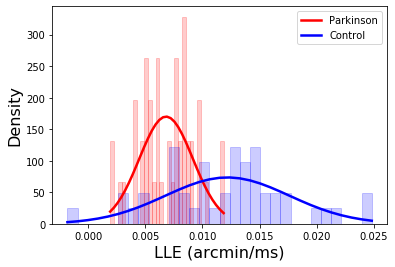

In [76]:
### Plotting the histograms and fitted distributions for x data 

_, bins_xp, _ = plt.hist(t_patientx, 30, density=1, alpha=0.2, color='r', histtype='bar', ec='r')
_, bins_xc, _ = plt.hist(t_controlx, 30, density=1, alpha=0.2, color='b', histtype='bar', ec='b')

mu_xp, sigma_xp = nm.fit(t_patientx)
mu_xc, sigma_xc = nm.fit(t_controlx)

best_xp = nm.pdf(bins_xp, mu_xp, sigma_xp)
best_xc = nm.pdf(bins_xc, mu_xc, sigma_xc)

plt.plot(bins_xp, best_xp, color='r', linewidth=2.5)
plt.plot(bins_xc, best_xc, color='b', linewidth=2.5)
plt.legend(['Parkinson', 'Control'])
plt.xlabel('LLE (arcmin/ms)', fontsize=16)
plt.ylabel('Density', fontsize=16)

Text(0, 0.5, 'Density')

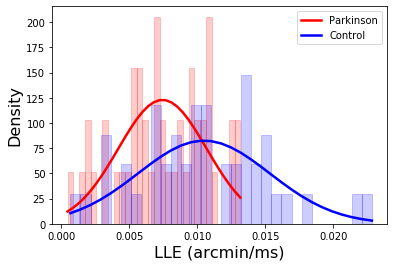

In [77]:
### Plotting the histograms and fitted distributions for y data 

_, bins_yp, _ = plt.hist(t_patienty, 30, density=1, alpha=0.2, color='r', histtype='bar', ec='r')
_, bins_yc, _ = plt.hist(t_controly, 30, density=1, alpha=0.2, color='b', histtype='bar', ec='b')

mu_yp, sigma_yp = nm.fit(t_patienty)
mu_yc, sigma_yc = nm.fit(t_controly)

best_yp = nm.pdf(bins_yp, mu_yp, sigma_yp)
best_yc = nm.pdf(bins_yc, mu_yc, sigma_yc)

plt.plot(bins_yp, best_yp, color='r', linewidth=2.5)
plt.plot(bins_yc, best_yc, color='b', linewidth=2.5)
plt.legend(['Parkinson', 'Control'])
plt.xlabel('LLE (arcmin/ms)', fontsize=16)
plt.ylabel('Density', fontsize=16)

Text(0, 0.5, 'Density')

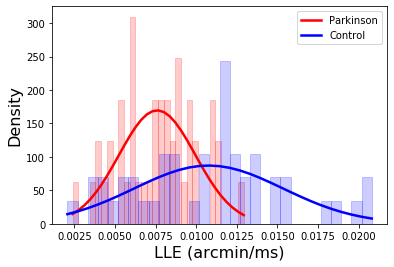

In [78]:
### Plotting the histograms and fitted distributions for r data 

_, bins_rp, _ = plt.hist(t_patientr, 30, density=1, alpha=0.2, color='r', histtype='bar', ec='r')
_, bins_rc, _ = plt.hist(t_controlr, 30, density=1, alpha=0.2, color='b', histtype='bar', ec='b')

mu_rp, sigma_rp = nm.fit(t_patientr)
mu_rc, sigma_rc = nm.fit(t_controlr)

best_rp = nm.pdf(bins_rp, mu_rp, sigma_rp)
best_rc = nm.pdf(bins_rc, mu_rc, sigma_rc)

plt.plot(bins_rp, best_rp, color='r', linewidth=2.5)
plt.plot(bins_rc, best_rc, color='b', linewidth=2.5)
plt.legend(['Parkinson', 'Control'])
plt.xlabel('LLE (arcmin/ms)', fontsize=16)
plt.ylabel('Density', fontsize=16)